In [154]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [48]:
# Import json data from flask app pulling from SQL database
json_url = 'http://127.0.0.1:5000/cardiovascular_data'

cvd_df = pd.read_json(json_url)
cvd_df.head()

,active,age,age_years,alco,ap_hi,ap_lo,bmi,bp_category,bp_category_encoded,cardio,cholesterol,gender,gluc,height,id,smoke,weight
0,1,18393,50,0,110,80,21.97,Hypertension Stage 1,Hypertension Stage 1,0,1,2,1,168,0,0,62.0
1,1,20228,55,0,140,90,34.93,Hypertension Stage 2,Hypertension Stage 2,1,3,1,1,156,1,0,85.0
2,0,18857,51,0,130,70,23.51,Hypertension Stage 1,Hypertension Stage 1,1,3,1,1,165,2,0,64.0
3,1,17623,48,0,150,100,28.71,Hypertension Stage 2,Hypertension Stage 2,1,1,2,1,169,3,0,82.0
4,0,17474,47,0,100,60,23.01,Normal,Normal,0,1,1,1,156,4,0,56.0


In [49]:
cvd_df.shape

(68205, 17)

In [50]:
# Dropped age and bp_category_encoded files. Age is just age in days, kept age in years, bp_category_encoded files
# repeats of bp_category column
cvd_df = cvd_df.drop(columns=['age','bp_category_encoded'])
cvd_df

,active,age_years,alco,ap_hi,ap_lo,bmi,bp_category,cardio,cholesterol,gender,gluc,height,id,smoke,weight
0,1,50,0,110,80,21.97,Hypertension Stage 1,0,1,2,1,168,0,0,62.0
1,1,55,0,140,90,34.93,Hypertension Stage 2,1,3,1,1,156,1,0,85.0
2,0,51,0,130,70,23.51,Hypertension Stage 1,1,3,1,1,165,2,0,64.0
3,1,48,0,150,100,28.71,Hypertension Stage 2,1,1,2,1,169,3,0,82.0
4,0,47,0,100,60,23.01,Normal,0,1,1,1,156,4,0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68200,1,52,0,120,80,26.93,Hypertension Stage 1,0,1,2,1,168,99993,1,76.0
68201,1,61,0,140,90,50.47,Hypertension Stage 2,1,2,1,2,158,99995,0,126.0
68202,0,52,1,180,90,31.35,Hypertension Stage 2,1,3,2,1,183,99996,0,105.0
68203,0,61,0,135,80,27.10,Hypertension Stage 1,1,1,1,2,163,99998,0,72.0


In [51]:
cvd_df.describe()

,active,age_years,alco,ap_hi,ap_lo,bmi,cardio,cholesterol,gender,gluc,height,id,smoke,weight
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000
mean,0.803548,52.823635,0.053134,126.434924,81.263925,27.510549,0.493688,1.363243,1.348625,1.225174,164.372861,49972.410498,0.087662,74.100688
std,0.397317,6.769909,0.224302,15.961685,9.143985,6.026394,0.499964,0.678080,0.476539,0.571288,8.176756,28852.138290,0.282805,14.288862
min,0.000000,29.000000,0.000000,90.000000,60.000000,3.470000,0.000000,1.000000,1.000000,1.000000,55.000000,0.000000,0.000000,11.000000
25%,1.000000,48.000000,0.000000,120.000000,80.000000,23.880000,0.000000,1.000000,1.000000,1.000000,159.000000,24991.000000,0.000000,65.000000
50%,1.000000,53.000000,0.000000,120.000000,80.000000,26.350000,0.000000,1.000000,1.000000,1.000000,165.000000,50008.000000,0.000000,72.000000
75%,1.000000,58.000000,0.000000,140.000000,90.000000,30.120000,1.000000,1.000000,2.000000,1.000000,170.000000,74878.000000,0.000000,82.000000
max,1.000000,64.000000,1.000000,180.000000,120.000000,298.670000,1.000000,3.000000,2.000000,3.000000,250.000000,99999.000000,1.000000,200.000000


In [52]:
# Check column names and datatypes
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   active       68205 non-null  int64  
 1   age_years    68205 non-null  int64  
 2   alco         68205 non-null  int64  
 3   ap_hi        68205 non-null  int64  
 4   ap_lo        68205 non-null  int64  
 5   bmi          68205 non-null  float64
 6   bp_category  68205 non-null  object 
 7   cardio       68205 non-null  int64  
 8   cholesterol  68205 non-null  int64  
 9   gender       68205 non-null  int64  
 10  gluc         68205 non-null  int64  
 11  height       68205 non-null  int64  
 12  id           68205 non-null  int64  
 13  smoke        68205 non-null  int64  
 14  weight       68205 non-null  float64
dtypes: float64(2), int64(12), object(1)
memory usage: 7.8+ MB


In [53]:
# Check number of unique values in each column
cvd_df.nunique()

active             2
age_years         28
alco               2
ap_hi             86
ap_lo             58
bmi             2336
bp_category        4
cardio             2
cholesterol        3
gender             2
gluc               3
height           106
id             68205
smoke              2
weight           278
dtype: int64

In [54]:
# Check for null values in data
cvd_df.isnull().sum()

active         0
age_years      0
alco           0
ap_hi          0
ap_lo          0
bmi            0
bp_category    0
cardio         0
cholesterol    0
gender         0
gluc           0
height         0
id             0
smoke          0
weight         0
dtype: int64

In [55]:
# Check for duplicate data
cvd_df.duplicated().sum()

0

In [56]:
# Check for correlation in the data
cvd_df_corr = pd.get_dummies(cvd_df)
print(cvd_df_corr.corr())

                                    active  age_years      alco     ap_hi  \
active                            1.000000  -0.010385  0.024339 -0.001409   
age_years                        -0.010385   1.000000 -0.029052  0.211314   
alco                              0.024339  -0.029052  1.000000  0.032536   
ap_hi                            -0.001409   0.211314  0.032536  1.000000   
ap_lo                            -0.001234   0.155777  0.036212  0.731812   
bmi                              -0.013353   0.085770  0.014555  0.230162   
cardio                           -0.037944   0.238875 -0.009038  0.433802   
cholesterol                       0.008658   0.154738  0.034184  0.195330   
gender                            0.005206  -0.024098  0.170719  0.060722   
gluc                             -0.008003   0.098212  0.009379  0.093151   
height                           -0.008241  -0.081974  0.094354  0.018544   
id                                0.003539   0.003810  0.000754  0.000251   

<Axes: >

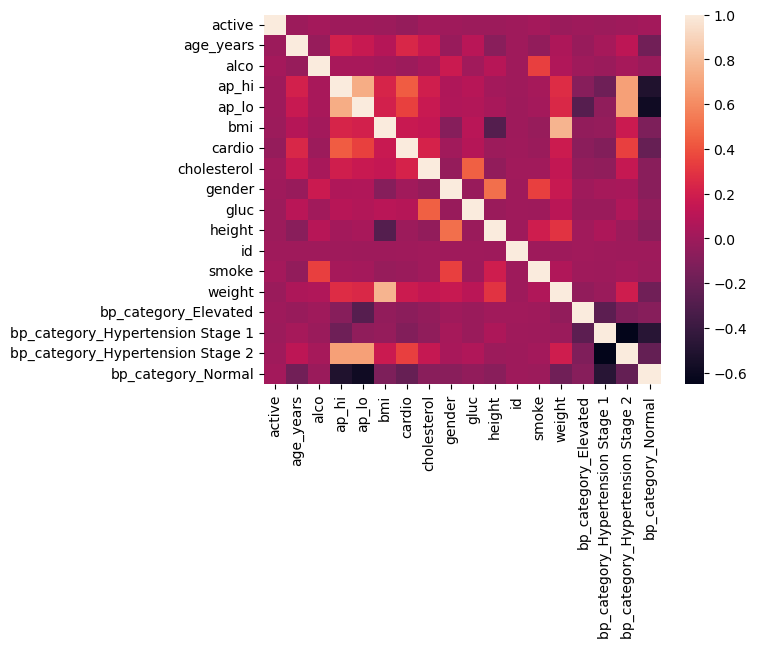

In [ ]:
# Generate heat map of correlation data
sns.heatmap(cvd_df_corr.corr(), annot=False)

In [58]:
# Create correlation matrix
correlation_matrix = cvd_df_corr.corr()
print(correlation_matrix)

                                    active  age_years      alco     ap_hi  \
active                            1.000000  -0.010385  0.024339 -0.001409   
age_years                        -0.010385   1.000000 -0.029052  0.211314   
alco                              0.024339  -0.029052  1.000000  0.032536   
ap_hi                            -0.001409   0.211314  0.032536  1.000000   
ap_lo                            -0.001234   0.155777  0.036212  0.731812   
bmi                              -0.013353   0.085770  0.014555  0.230162   
cardio                           -0.037944   0.238875 -0.009038  0.433802   
cholesterol                       0.008658   0.154738  0.034184  0.195330   
gender                            0.005206  -0.024098  0.170719  0.060722   
gluc                             -0.008003   0.098212  0.009379  0.093151   
height                           -0.008241  -0.081974  0.094354  0.018544   
id                                0.003539   0.003810  0.000754  0.000251   

In [59]:
# Sort correlation values based on cardio column that will be the target data
target_correlation = correlation_matrix['cardio'].abs().sort_values(ascending=False)
print(target_correlation)

cardio                              1.000000
ap_hi                               0.433802
ap_lo                               0.342900
bp_category_Hypertension Stage 2    0.339099
age_years                           0.238875
cholesterol                         0.220778
bp_category_Normal                  0.217798
weight                              0.177829
bmi                                 0.162880
bp_category_Hypertension Stage 1    0.107116
gluc                                0.088905
bp_category_Elevated                0.074598
active                              0.037944
smoke                               0.016567
height                              0.011276
alco                                0.009038
gender                              0.006098
id                                  0.003808
Name: cardio, dtype: float64


In [69]:
# seperate columns into features and target, drop features height, weight, active, gluc, gender, alco, and smoke due to low correlation
X = cvd_df.drop(columns = ['cardio', 'id', 'height', 'weight', 'active', 'gluc', 'gender', 'alco', 'smoke'])
y = cvd_df['cardio']

In [70]:
# Create dummy columns for features
X = pd.get_dummies(X, dtype='int')

In [71]:
#Display first five rows of feature data
X.head()

,age_years,ap_hi,ap_lo,bmi,cholesterol,bp_category_Elevated,bp_category_Hypertension Stage 1,bp_category_Hypertension Stage 2,bp_category_Normal
0,50,110,80,21.97,1,0,1,0,0
1,55,140,90,34.93,3,0,0,1,0
2,51,130,70,23.51,3,0,1,0,0
3,48,150,100,28.71,1,0,0,1,0
4,47,100,60,23.01,1,0,0,0,1


In [72]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [73]:
X_train.shape

(51153, 9)

In [74]:
X_test.shape

(17052, 9)

In [75]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [116]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=64, activation="relu", input_dim=9))
nn_model.add(tf.keras.layers.Dense(units=64, activation="gelu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_focal_crossentropy", optimizer="sgd", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=3)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - accuracy: 0.6698 - loss: 0.1540
Epoch 2/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.7228 - loss: 0.1422
Epoch 3/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.7234 - loss: 0.1417
Epoch 4/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7249 - loss: 0.1419
Epoch 5/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.7262 - loss: 0.1411
Epoch 6/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.7276 - loss: 0.1414
Epoch 7/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.7268 - loss: 0.1408
Epoch 8/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.7296 - loss: 0.1406
Epoch 9/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.7296 - loss: 0.1403
Epoch 10/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.7288 - loss: 0.1400
Epoch 11/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.7294 - loss: 0.1402
Epoch 12

In [160]:
history = nn_model.fit(X_train_scaled, y_train,epochs=50, batch_size=4)

Epoch 1/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 8s 557us/step - accuracy: 0.7363 - loss: 0.1387
Epoch 2/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 8s 586us/step - accuracy: 0.7329 - loss: 0.1393
Epoch 3/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 540us/step - accuracy: 0.7342 - loss: 0.1384
Epoch 4/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 522us/step - accuracy: 0.7325 - loss: 0.1393
Epoch 5/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 544us/step - accuracy: 0.7323 - loss: 0.1395
Epoch 6/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 542us/step - accuracy: 0.7328 - loss: 0.1396
Epoch 7/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 530us/step - accuracy: 0.7330 - loss: 0.1386
Epoch 8/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 539us/step - accuracy: 0.7314 - loss: 0.1393
Epoch 9/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 535us/step - accuracy: 0.7378 - loss: 0.1376
Epoch 10/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 522us/step - accuracy: 0.7339 - loss: 0.1393
Epoch 11/50
12789/12789 ━━━━━━━━━━━━━━━━━━━━ 7s 533us/step - accuracy: 0.7326 -

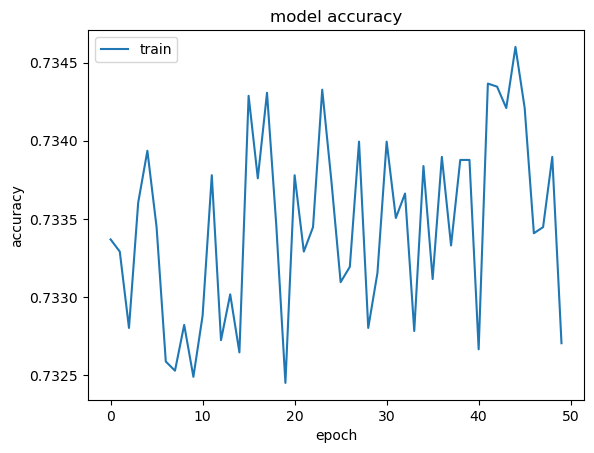

In [161]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('nnmodel.png')
plt.show()

In [147]:
# Create a Logistic Regression Model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=1000,
                                random_state=78)
classifier

LogisticRegression(max_iter=1000, random_state=78)

In [148]:
# Train the data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=78)

In [149]:
# Score the model
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.7237307684788771
Testing Data Score: 0.7254281022753929


In [150]:
# Predict outcomes for test data set
predictions = classifier.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
5,1,1
6,1,1
7,0,0
8,0,0
9,0,0


In [156]:
# Display the accuracy score for the test dataset.
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.7254281022753929


In [152]:
# Print Confusion Matrix and Classification report for Logistics Regression model
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Confusion Matrix:
 [[6837 1660]
 [3022 5533]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.80      0.74      8497
           1       0.77      0.65      0.70      8555

    accuracy                           0.73     17052
   macro avg       0.73      0.73      0.72     17052
weighted avg       0.73      0.73      0.72     17052



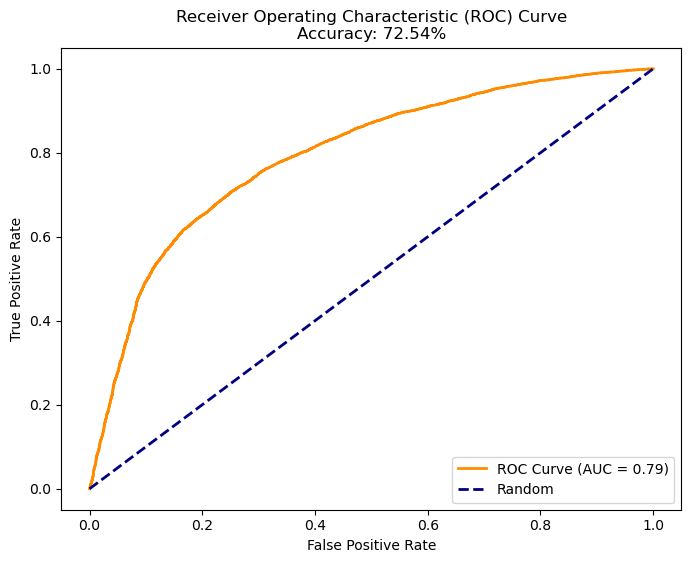

In [159]:
# Plot ROC Curve
# Found on https://www.geeksforgeeks.org/ml-logistic-regression-using-python/
y_prob = classifier.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
		label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
	accuracy * 100))
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()


In [82]:
# Get the target variables. 
target = cvd_df['cardio']
target_names = ['Cardiovascular Disease', 'Healthy']

In [83]:
# Get the features. 
data = cvd_df.drop(columns= ['cardio', 'id', 'height', 'active', 'gluc', 'gender', 'alco', 'smoke'], axis=1)
data = pd.get_dummies(data, dtype='int')
feature_names = data.columns
data.head()

,age_years,ap_hi,ap_lo,bmi,cholesterol,weight,bp_category_Elevated,bp_category_Hypertension Stage 1,bp_category_Hypertension Stage 2,bp_category_Normal
0,50,110,80,21.97,1,62.0,0,1,0,0
1,55,140,90,34.93,3,85.0,0,0,1,0
2,51,130,70,23.51,3,64.0,0,1,0,0
3,48,150,100,28.71,1,82.0,0,0,1,0
4,47,100,60,23.01,1,56.0,0,0,0,1


In [84]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [85]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [86]:
# Model Accuracy
print('Test Acc: %.3f' % model.score(X_test, y_test))

Test Acc: 0.713


In [87]:
# Calculate the classification report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

                        precision    recall  f1-score   support

Cardiovascular Disease       0.69      0.79      0.73      8576
               Healthy       0.75      0.64      0.69      8476

              accuracy                           0.71     17052
             macro avg       0.72      0.71      0.71     17052
          weighted avg       0.72      0.71      0.71     17052



In [88]:
# Used cross validation to find the best value for the number of neighbors for the KneighborsClassifier
# Found this method at https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn
k_values = [i for i in range (1,31)]
scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

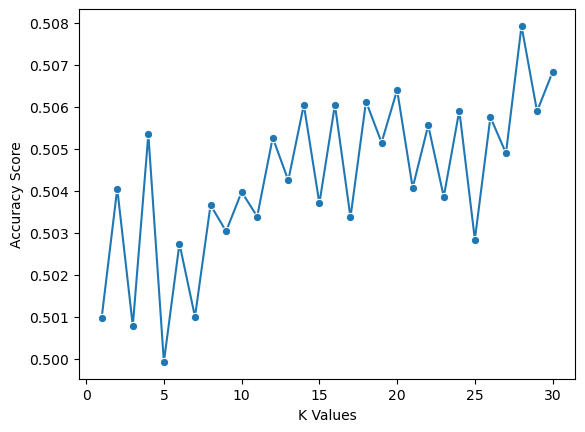

In [89]:
# Plot the values
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [90]:
# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=28)

In [91]:
# Train the model using the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=28)

In [92]:
# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)

In [93]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55      8576
           1       0.49      0.39      0.44      8476

    accuracy                           0.50     17052
   macro avg       0.50      0.50      0.49     17052
weighted avg       0.50      0.50      0.49     17052



In [94]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [95]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=800, random_state=78)


In [96]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

C:\Users\mrybi\AppData\Local\Temp\ipykernel_4680\3145931551.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rf_model = rf_model.fit(X_train_scaled, y_train.ravel())


In [97]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [98]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [99]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5735,2762
Actual 1,2882,5673


Accuracy Score : 0.6690124325592306
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      8497
           1       0.67      0.66      0.67      8555

    accuracy                           0.67     17052
   macro avg       0.67      0.67      0.67     17052
weighted avg       0.67      0.67      0.67     17052

